# Two‑Stage Blink Classifier
Skeleton notebook created 2025-05-15 14:07:12.703580

### Imports
Run once when starting/restarting

In [3]:
import numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import snntorch as snn
from snntorch import utils
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("device =", device)

import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

import brevitas
import brevitas.nn as qnn


device = cpu


### Parameters
Run once when starting/restarting

In [4]:
import numpy as np, pandas as pd, torch, snntorch as snn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from snntorch import surrogate, utils
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV              = "./data/DM_OUT_S14_50s-90s.csv"
SAMPLING_RATE_HZ = 256
WIN_MS           = 60                               # 200-ms windows
WIN              = int(WIN_MS/1000 * SAMPLING_RATE_HZ) #51.2 samples
STRIDE           = WIN//8                          #  8.5 ms
THR_VOLT         = 1.7                               # spike threshold
BATCH            = 32
EPOCHS           = 40
LR               = 1e-4
THRESH_PROB      = 0.30                              # decision cut-off

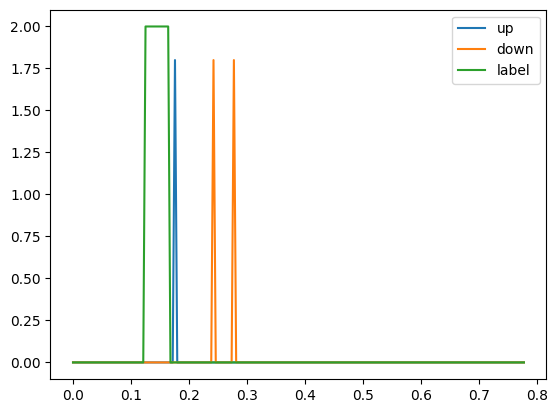

mean hard-spikes (blink windows): 1.4961861
mean hard-spikes (no-blink)    : 0.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np

start = 0
multiplier = 1
end = 200 * multiplier
t = np.arange(end)/256     # first 2 000 samples
df = pd.read_csv(CSV)
plt.plot(t, df["/spk_up Y"].iloc[:end], label="up")
plt.plot(t, df["/spk_down Y"].iloc[:end], label="down")
plt.plot(t, df["/label Y"].iloc[:end], label="label")
plt.legend(); plt.show()
thr = 1.7
# positive spikes  → likely *hard*
spk_up_pos   = (df["/spk_up Y"]   >  thr).astype(np.float32)
spk_down_neg = (df["/spk_down Y"] > thr).astype(np.float32)
# everything else is zero
win_hard = spk_up_pos[start:end].any()        # 1 if hard blink
win_soft = spk_down_neg[start:end].any()      # 1 if soft blink
blink = [(spk_up_pos[s:s+WIN_MS].any() or spk_down_neg[s:s+WIN_MS].any()) 
		 for s in range(0, len(spk_up_pos) - WIN_MS, STRIDE)]
cnt_hard = [spk_up_pos[s:s+WIN_MS].sum() for s in range(0, len(spk_up_pos) - WIN_MS, STRIDE)]
cnt_soft = [spk_down_neg[s:s+WIN_MS].sum() for s in range(0, len(spk_down_neg) - WIN_MS, STRIDE)]

print("mean hard-spikes (blink windows):", np.mean([c for c, t in zip(cnt_hard, blink) if t]))
print("mean hard-spikes (no-blink)    :", np.mean([c for c, t in zip(cnt_hard, blink) if not t]))

### Window Extraction
Run once when starting/restarting or when WINDOW size is changed


In [6]:
import numpy as np
import torch

df  = pd.read_csv(CSV)
up  = (df["/spk_up Y"].abs()   > THR_VOLT).astype(np.float32).to_numpy()
dn  = (df["/spk_down Y"].abs() > THR_VOLT).astype(np.float32).to_numpy()
lab = df["/label Y"].to_numpy()           # 0 | 1 | 2
# LABEL_MARGIN = int(0.1 * SAMPLING_RATE_HZ)
LABEL_MARGIN = WIN
X_windows, y_labels = [], []
for s in range(0, len(df) - WIN + 1, STRIDE):
    e = s + WIN

    # 1) build your [T,2] spike raster
    x_win = np.stack([up[s:e], dn[s:e]], axis=1).astype(np.float32)

    # 2) decide on the window label
    ls = max(0, s - LABEL_MARGIN)
    le = min(len(df), e + LABEL_MARGIN)
    lab_max = lab[ls:le].max()

    # map: 2 → soft (0), 1 → hard (1), else → no-blink (2)
    if   lab_max == 2: label = 0 # soft
    elif lab_max == 1: label = 1 # hard
    else:              label = 2 # no-blink

    X_windows.append(x_win)
    y_labels.append(label)

# stack into tensors
X = torch.tensor(np.stack(X_windows))                  # shape [N, WIN, 2]
y = torch.tensor(y_labels, dtype=torch.long)           # shape [N] with values 0/1/2

# quick sanity check:
unique, counts = np.unique(y.numpy(), return_counts=True)
print("class counts:", dict(zip(unique, counts)))


class counts: {0: 330, 1: 522, 2: 9023}


## Window Visualisation

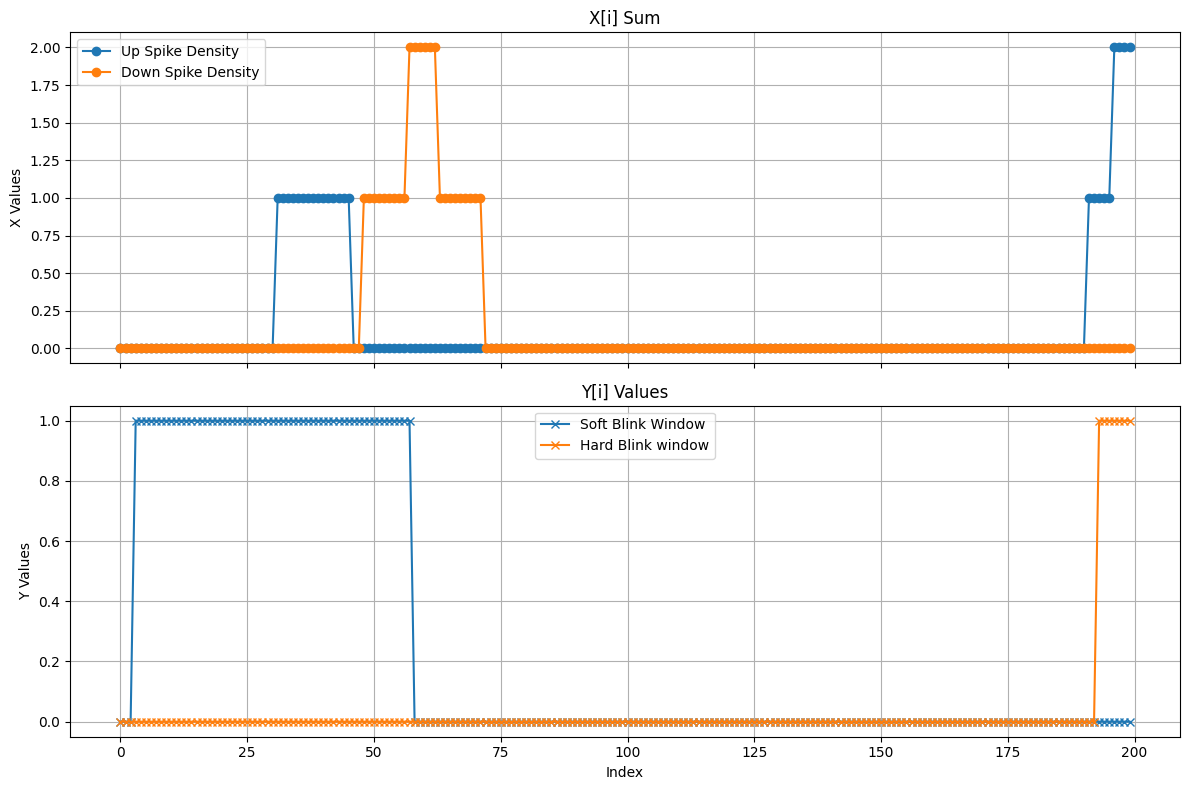

In [7]:
RANGE = min(200, X.size(0))  # Ensure RANGE does not exceed the size of X

x_range = range(RANGE)
x_sums = [X[i].sum(0).tolist() for i in x_range]
y_values = [y[i].item() for i in x_range]  # Access individual elements of y

x_col1 = [x[0] for x in x_sums]
x_col2 = [x[1] for x in x_sums]
y_col1 = [1 if y_val == 0 else 0 for y_val in y_values]  # Soft blink (mapped from 0)
y_col2 = [1 if y_val == 1 else 0 for y_val in y_values]  # Hard blink (mapped from 1)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot X values
axs[0].plot(x_range, x_col1, label="Up Spike Density", marker='o')
axs[0].plot(x_range, x_col2, label="Down Spike Density", marker='o')
axs[0].set_ylabel("X Values")
axs[0].set_title("X[i] Sum")
axs[0].legend()
axs[0].grid()

# Plot Y values
axs[1].plot(x_range, y_col1, label="Soft Blink Window", marker='x')
axs[1].plot(x_range, y_col2, label="Hard Blink window", marker='x')
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Y Values")
axs[1].set_title("Y[i] Values")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

####  Build the 2-4-4-2 Izh network
Run once when starting/restarting


In [8]:
def gen_seq_model(topo, neuron_layer, neuron_params={}, bias=False, quant_weights=False, quant_states=False):
    state_quant = SF.quant.state_quant(num_bits=8, uniform=True, thr_centered=False) if quant_states else None
    layers = []

    neuron_layer_classes = {
        'NormIzh': snn.NormIzh,
        'Leaky': snn.Leaky,
    }

    if neuron_layer not in neuron_layer_classes:
        raise ValueError(f"Invalid neuron_layer '{neuron_layer}'. Available options: {list(neuron_layer_classes.keys())}")

    neuron_class = neuron_layer_classes[neuron_layer]

    for i in range(len(topo) - 1):
        if quant_weights:
            layers.append(qnn.QuantLinear(
                topo[i], topo[i + 1], bias=bias,
                weight_quant=brevitas.quant.Int8WeightPerTensorFixedPoint, weight_bit_width=4))
        else:
            layers.append(nn.Linear(topo[i], topo[i + 1], bias=bias))

        if i < len(topo) - 2:
            layers.append(neuron_class(init_hidden=True, state_quant=state_quant, **neuron_params))

    layers.append(neuron_class(init_hidden=True, output=True, state_quant=state_quant, **neuron_params))

    return nn.Sequential(*layers)

In [9]:
topo = [2, 4, 4, 2]                          # ←N requested topology
model = gen_seq_model(
    topo=topo,
    neuron_layer='NormIzh', # 'Leaky' or 'NormIzh'
    neuron_params={'neuron_type': 'RS'},
    bias=True,
    quant_weights=False,
    quant_states=False,
).to(device)

# lif_model = gen_seq_model(
#     topo=topo,
#     neuron_layer='Leaky',
#     neuron_params={'beta': 0.9},
#     bias=True,
#     quant_weights=False,
#     quant_states=False,
# ).to(device)

Added NormIzh() to instances: [NormIzh()].
Added NormIzh() to instances: [NormIzh(), NormIzh()].
Added NormIzh() to instances: [NormIzh(), NormIzh(), NormIzh()].


### Dataset & balanced sampler - Trainloader

In [10]:
import numpy as np

# Convert to numpy for easy indexing
X_np = X.numpy()
y_np = y.numpy()

# Indices for each class
idx_soft = np.where(y_np == 0)[0]
idx_hard = np.where(y_np == 1)[0]
idx_none = np.where(y_np == 2)[0]

# Downsample "no-blink" to match the largest minority class
n_samples = max(len(idx_soft), len(idx_hard))
np.random.seed(42)

if len(idx_none) > 0:
	idx_none_down = np.random.choice(idx_none, size=n_samples, replace=False)
	# Combine indices and shuffle
	balanced_idx = np.concatenate([idx_soft, idx_hard, idx_none_down])
else:
	print("Warning: 'no-blink' class is empty. Skipping downsampling for this class.")
	balanced_idx = np.concatenate([idx_soft, idx_hard])

np.random.shuffle(balanced_idx)

# Create balanced tensors
X_bal = torch.tensor(X_np[balanced_idx])
y_bal = torch.tensor(y_np[balanced_idx])

print("Balanced class counts:", np.bincount(y_bal.numpy()))

Balanced class counts: [330 522 522]


In [11]:
class BlinkDS(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# 80 / 20 split - generate train/test sets

# Uncomment the next 4-line for unbalanced data
# perm = torch.randperm(len(X)) 
# split = int(0.8*len(X)) 
# train_idx, test_idx = perm[:split], perm[split:]
# ds_tr, ds_te = BlinkDS(X[train_idx], y[train_idx]), BlinkDS(X[test_idx], y[test_idx])

# Uncomment the next 4-line for balanced data
perm = torch.randperm(len(X_bal))   # For balanced data: use X_bal and y_bal
split = int(0.8*len(X_bal))
train_idx, test_idx = perm[:split], perm[split:]
ds_tr, ds_te = BlinkDS(X_bal[train_idx], y_bal[train_idx]), BlinkDS(X_bal[test_idx], y_bal[test_idx])

# WEIGHTS: balance the positives
# is_soft = ds_tr.y==0 ; is_hard = ds_tr.y==1
# w_soft  = 0.25 / is_soft.sum()
# w_hard  = 0.25 / is_hard.sum()
# w_none  = 0.50 / (len(ds_tr)-is_soft.sum()-is_hard.sum())


### Weights: Loss, optimiser, imbalance weights

Use the normalized or inverted weights to skew towards minority classes. Use direct weights to skew towards the majority class.

Trying Focal Loss Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma    = gamma
        self.alpha    = alpha  # Tensor of shape [num_classes], or None
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits: [B, C], targets: [B] with ints in 0..C-1
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt      = torch.exp(-ce_loss)                  # pt = prob(correct)
        loss    = (1 - pt)**self.gamma * ce_loss       # focal modulation

        if self.alpha is not None:
            # apply class-wise weighting
            at = self.alpha.to(logits.device)
            loss = loss * at[targets]

        if self.reduction=='mean':
            return loss.mean()
        elif self.reduction=='sum':
            return loss.sum()
        else:
            return loss


In [13]:
## Worst-case example of class imbalance:
# weights = torch.tensor([1.0, 1.0, 1.0], device=device) 
# counts = [sum(1 for label in y_bal if label == c) for c in range(3)]
# weights = torch.tensor([2.1023257, 1.8677686, 1.0], device=device) # Skewed towards no-blink

# # Normalize the class weights to sum=1 based on the counts (Works well for small labels i.e. soft, hard)
# # y_labels is your list/array of ints in {0=soft,1=hard,2=no-blink}
# counts = np.bincount(y_labels, minlength=3)      # e.g. [13,24,645]
# inv_freq = 1.0 / counts                          # → [1/13, 1/24, 1/645]
# weights  = inv_freq / inv_freq.sum()             # normalize to sum=1 (optional)

# # Initialize count and weight arrays
counts = [0] * 3
weights = [0] * 3

# Calculate class counts and weights
# counts = [sum(1 for label in y_labels if label == c) for c in range(3)] # Uncomment for unbalanced data
counts = [sum(1 for label in y_bal if label == c) for c in range(3)]
max_count = max(counts)
weights = [max_count / c if c > 0 else 0 for c in counts]  # avoid division by zero

print("Class counts:", counts)
print("Class weights:", weights)

# Convert weights to a tensor and define the loss function
class_weights = torch.tensor(weights, dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Focal Loss with class weights
# alpha = torch.tensor([1.0, 1.0, 1.5])   # soft, hard, no-blink
# loss_fn = FocalLoss(alpha=alpha, gamma=2.0)


Class counts: [330, 522, 522]
Class weights: [1.5818181818181818, 1.0, 1.0]


Complete the trainloader using the generated weights

In [14]:

# weights = torch.where(is_soft, w_soft, torch.where(is_hard, w_hard, w_none))
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

ldr_tr = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler)
ldr_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False)


# print("Soft weights:", w_soft.item())
# print("Hard weights:", w_hard.item())
# print("None weights:", w_none.item())

#### Run Only to Generate Weights

In [17]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

# — 1) Gather your integer labels from the train dataset —
#    Assumes train_dataset[i] → (X[i], y[i]) where y[i] ∈ {0,1,2}
y_list = []
for Xb, yb in ldr_tr:
    y_list.extend(yb.cpu().numpy())
y_train = np.array(y_list, dtype=int)

# — 2) Compute class counts and max–count weights —
counts    = np.bincount(y_train, minlength=2)   # e.g. [#soft, #hard, #no-blink]
max_count = counts.max()                       # the size of the largest class
weights   = max_count / counts                  # e.g. [43, 26.9, 1.0]
print("Class counts:", counts)
print("Raw weights : ", weights)

# turn into a torch tensor on your device
class_weights = torch.tensor(weights, dtype=torch.float, device=device)

# — 3) Plug into CrossEntropyLoss —
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# — 4) Also build per-sample weights for oversampling —
#    so that your DataLoader draws from minority classes more often:
sample_weights = weights[y_train]               # pick weight[c] for each sample’s class
sample_weights = torch.tensor(sample_weights,
                              dtype=torch.double,
                              device=device)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# — 5) Rebuild your train_loader with the sampler —
ldr_tr = DataLoader(
    y_train,
    batch_size=BATCH,
    sampler=sampler,
    drop_last=True,
    num_workers=4,
    pin_memory=True
)

# validation / test loaders stay the same:
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, ...)
# test_loader = ...

print("Using class_weights:", class_weights.cpu().numpy())


c:\Users\kaushikl\OneDrive - University of Maryland\UMD\Project_Research\SNN Training (Izh)\backpropizh\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Class counts: [0 0]
Raw weights :  [nan nan]


C:\Users\kaushikl\AppData\Local\Temp\ipykernel_30852\219586252.py:16: RuntimeWarning: invalid value encountered in divide
  weights   = max_count / counts                  # e.g. [43, 26.9, 1.0]


ValueError: num_samples should be a positive integer value, but got num_samples=0

## Training loop

c:\Users\kaushikl\OneDrive - University of Maryland\UMD\Project_Research\SNN Training (Izh)\backpropizh\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ZeroDivisionError: float division by zero

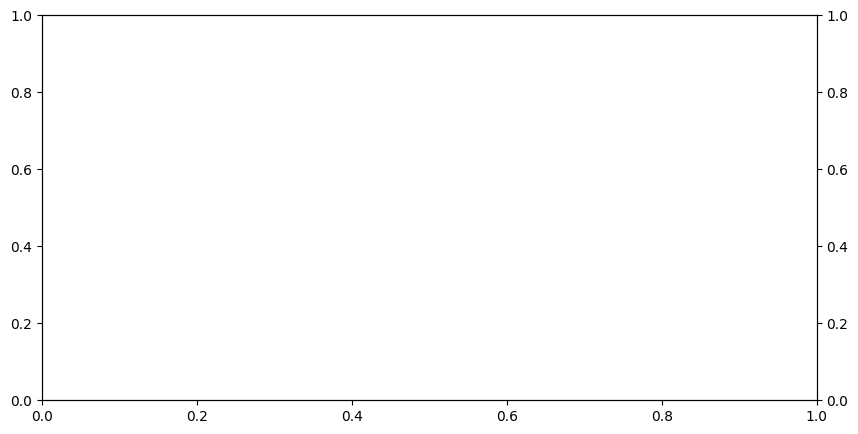

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

plt.ion()
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

train_losses    = []
val_accuracies  = []
val_confidences = []

# Define the optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_corr = 0
    running_tot  = 0
    
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_corr = 0
    running_tot  = 0

    # ——— TRAINING ———
    # for Xb, yb in ldr_tr:
    for Xb, yb in ldr_tr:
        Xb, yb = Xb.to(device), yb.to(device)        # yb is LongTensor [B]

        utils.reset(model)
        spk = []
        for t in range(Xb.size(1)):
            out, *_ = model(Xb[:,t,:])
            spk.append(out)
        logits = torch.stack(spk).sum(0)             # [B, 3]
        
        # ---- key change: use CrossEntropyLoss on integer labels ----
        
        # Ensure target values are within bounds
        yb = torch.clamp(yb, 0, logits.size(1) - 1)
        # Adjust the weight tensor to match the number of classes in logits
        if loss_fn.weight is not None and loss_fn.weight.size(0) != logits.size(1):
            loss_fn.weight = None  # Reset weight if it doesn't match the number of classes

        ce_loss = loss_fn(logits, yb)               # loss_fn = nn.CrossEntropyLoss()
        l1_reg  = 1e-4 * logits.abs().mean()        # optional L1 on logits
        loss    = ce_loss + l1_reg

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)                # [B]
        running_corr += (preds == yb).sum().item()
        running_tot  += Xb.size(0)

    train_losses.append(running_loss / running_tot)

    # ——— VALIDATION ———
    model.eval()
    corr = tot = 0
    confidences = []

    with torch.no_grad():
        for Xb, yb in ldr_te:
            Xb, yb = Xb.to(device), yb.to(device)
            utils.reset(model)

            spk = []
            for t in range(Xb.size(1)):
                out, *_ = model(Xb[:,t,:])
                spk.append(out)
            logits = torch.stack(spk).sum(0)

            # softmax → probabilities, pick max as “confidence”
            probs = F.softmax(logits, dim=1)
            conf_batch = probs.max(dim=1)[0].cpu().numpy()
            confidences.extend(conf_batch)

            preds = probs.argmax(dim=1)
            corr += (preds == yb).sum().item()
            tot  += Xb.size(0)

    val_accuracies.append(corr / tot)
    val_confidences.append(float(np.mean(confidences)))

    # ——— live plot ———
    clear_output(wait=True)
    ax1.cla(); ax2.cla()
    epochs = list(range(1, len(train_losses)+1))

    ax1.plot(epochs, train_losses, label="Train Loss", color='tab:red')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2.plot(epochs, val_accuracies,  label="Val Acc",  color='tab:blue')
    ax2.plot(epochs, val_confidences, label="Val Conf", color='tab:green')
    ax2.set_ylabel("Accuracy/Confidence", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # combined legend
    l1, lb1 = ax1.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax2.legend(l1 + l2, lb1 + lb2, loc='upper left')

    ax1.set_title(f"Epoch {epoch:2d}: val-acc={corr/tot:.3f}")
    plt.tight_layout()
    display(fig)
    plt.pause(0.01)

plt.ioff()
plt.show()


### Test Report

In [ ]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

# 1) switch to eval mode
model.eval()

all_labels = []  # true class indices
all_preds  = []  # predicted class indices
test_loader = DataLoader(ds_te, batch_size=32, shuffle=False)
# 2) no gradients needed
with torch.no_grad():
    for Xb, yb in test_loader:
        # move to device
        Xb, yb = Xb.to(device), yb.to(device)   # yb.shape = [B], dtype=torch.long
        
        # reset any internal state if needed
        utils.reset(model)
        
        # 3) accumulate spikes over time
        spk = []
        for t in range(Xb.size(1)):
            out, *_ = model(Xb[:, t, :])
            spk.append(out)
        logits = torch.stack(spk).sum(0)         # shape [B, 3]
        
        # 4) pick the highest‐scoring class
        preds = logits.argmax(dim=1)             # shape [B]
        
        # collect
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# convert to numpy arrays
y_true_idx = np.array(all_labels, dtype=int)
y_pred_idx = np.array(all_preds,  dtype=int)

# 5) print multiclass report
print("Classification Report:\n", 
      classification_report(
          y_true_idx, y_pred_idx,
          target_names=['soft', 'hard', 'no-blink'],
          zero_division=0
      ))

print("Confusion Matrix:\n", confusion_matrix(y_true_idx, y_pred_idx))


NameError: name 'model' is not defined

## Confusion matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
labels = ['soft', 'hard', 'no-blink']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Weights Visualisation


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Find all Linear layers in your model
linear_layers = [layer for layer in model if isinstance(layer, (nn.Linear, qnn.QuantLinear))]

layer_names = ["Input→Hidden1", "Hidden1→Hidden2", "Hidden2→Output"]
for idx, (layer, name) in enumerate(zip(linear_layers, layer_names)):
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(6,4))
    sns.heatmap(weights, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
    plt.title(f"Weights: {name} (shape {weights.shape})")
    plt.xlabel("From neuron")
    plt.ylabel("To neuron")
    plt.show()

NameError: name 'model' is not defined

### Inference on unseen data

In [ ]:
def predict_window(raw_up, raw_dn):
    up  = (raw_up > THR_VOLT).astype(np.float32)
    dn  = (raw_dn > THR_VOLT).astype(np.float32)
    x   = torch.from_numpy(np.stack([up,dn],1)).unsqueeze(0).to(device)

    utils.reset(model); spk=[]
    for t in range(x.size(1)):
        o,*_ = model(x[:,t,:]); spk.append(o)
    logits = torch.stack(spk).sum(0)
    probs  = torch.sigmoid(logits)[0]
    if probs.max() < THRESH_PROB:
        return "no-blink"
    return "soft" if probs[0] > probs[1] else "hard"
